# Dealing with Spatial and Temporal Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

<b>Spatial/temporal collinearity</b> เป็นการที่ feature หนึ่งมี correlation กับตำแหน่ง/เวลา

สำหรับข้อมูลที่มี spatial/temporal collinearity การทำ splitting อย่างสุ่ม จะได้ test set ที่คล้ายกับ training set มากเกินไป ทำให้ model performance สูงเกินจริง ดังนั้นเราจะทำ splitting โดยแบ่งข้อมูลเป็นก้อนใหญ่ ๆ ไปเลย วิธีนี้ใช้ได้ดีหากข้อมูล <b>stationary</b> (ข้อมูลที่มี mean และ variance ไม่เปลี่ยนไปตามตำแหน่งหรือเวลา)

<img src="../images/stationarity.png" width="500" /><br />

- สำหรับ spatial data เราจะแบ่งพื้นที่ออกเป็น 2 พื้นที่ใหญ่ ๆ ข้อมูลในพื้นที่หนึ่งถูกใช้เป็น training set และข้อมูลในอีกพื้นที่หนึ่งถูกใช้เป็น test set

<img src="../images/split_area.png" width="300" /><br />

- สำหรับ temporal data เราจะแบ่งเวลาออกเป็น 2 ช่วงเวลาใหญ่ ๆ ข้อมูลในช่วงเวลาที่เก่ากว่าถูกใช้เป็น training set และข้อมูลในช่วงเวลาที่ใหม่กว่าถูกใช้เป็น test set

Cross validation สามารถทำได้ แต่ซับซ้อนมาก

สำหรับข้อมูลที่ไม่ stationary เราต้อง detrend (เอา trend ไปลบกับข้อมูลเดิม) ได้ model residual ก่อนเอาไป train เสร็จแล้วจึงเอา trend บวกกลับเข้าไป

In [2]:
# Thanks to Prof. Michael Pyrcz for data
# Import data and drop duplicates
data = pd.read_csv("../data/poro-perm.csv").drop_duplicates()
data

,X,Y,Facies,Porosity,Perm,AI
0,100.0,900.0,1.0,0.100187,1.363890,5110.699751
1,100.0,800.0,0.0,0.107947,12.576845,4671.458560
2,100.0,700.0,0.0,0.085357,5.984520,6127.548006
3,100.0,600.0,0.0,0.108460,2.446678,5201.637996
4,100.0,500.0,0.0,0.102468,1.952264,3835.270322
...,...,...,...,...,...,...
256,780.0,669.0,1.0,0.175642,629.138468,3140.692477
257,50.0,779.0,1.0,0.091725,0.656564,6197.834381
258,430.0,589.0,1.0,0.139057,13.124324,3981.017070
259,130.0,489.0,0.0,0.099351,8.681915,4954.088777


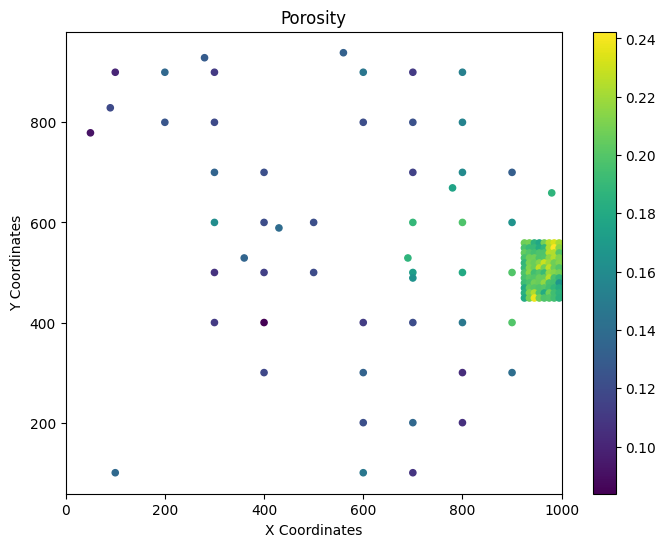

In [3]:
# Here I only want to illustrate the spatial variability of porosity of sand.
# sand มี Facies=1 และ shale มี Facies=0

# Required features
sand = data[data["Facies"] == 1]
x = sand['X'].values
y = sand['Y'].values
porosity = sand["Porosity"].values
permeability = sand["Perm"].values  # will be used later

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(x, y, c=porosity, s=20)
ax.set(xlabel="X Coordinates", ylabel="Y Coordinates", title="Porosity", xlim=(0, 1000))
plt.colorbar(sc);

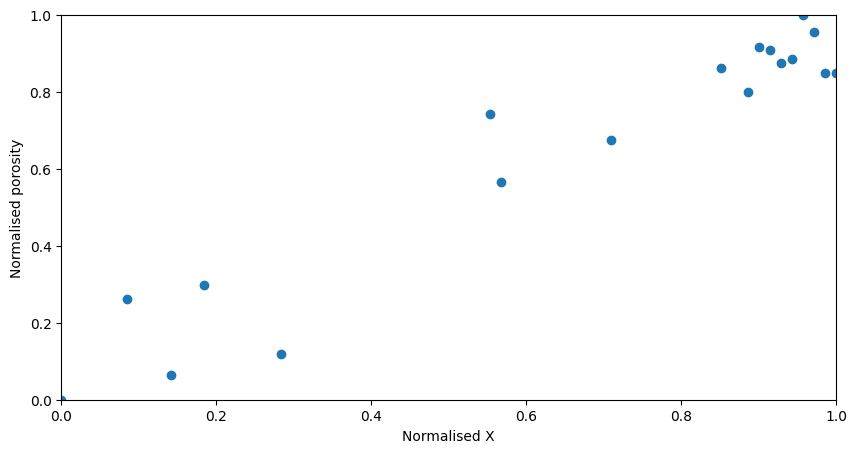

In [4]:
# Explore horizontal (X) trend of porosity
# We can see the a clear correlation from the plot below

# Use datapoints with Y = 400-600
corr_df = sand[(sand['Y'] > 400) & (sand['Y'] < 600)][['X', "Porosity", "Perm"]]
# Average their porosity if they have the same X
corr_df = corr_df.groupby('X').mean().reset_index()
# Normalise X and porosity
corr_df = pd.DataFrame(MinMaxScaler().fit_transform(corr_df).T, corr_df.columns).T

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(corr_df['X'], corr_df["Porosity"])
ax.set(xlabel="Normalised X", ylabel="Normalised porosity", xlim=(0, 1), ylim=(0, 1));

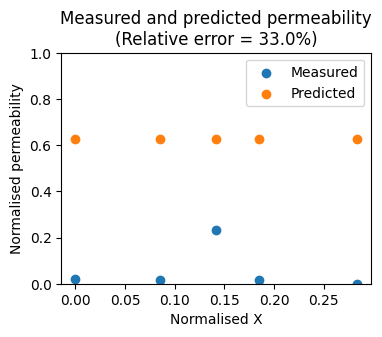

In [5]:
# Try to predict permeability from porosity, ignoring spatial collinearity

# Geographic train-test split (first 30% is test set)
boundary = round(0.3*len(corr_df))
X_test = corr_df["Porosity"][:boundary].values.reshape(-1, 1)
y_test = corr_df["Perm"][:boundary].values
X_train = corr_df["Porosity"][boundary:].values.reshape(-1, 1)
y_train = corr_df["Perm"][boundary:].values
# Predict using a KNN regressor
knn = KNeighborsRegressor().fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Show the prediction result and error
error = mean_squared_error(y_test, y_pred)*100
fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(corr_df['X'][:boundary], y_test, label="Measured")
ax.scatter(corr_df['X'][:boundary], y_pred, label="Predicted")
ax.set(
    title=f"Measured and predicted permeability\n(Relative error = {error:.1f}%)",
    xlabel="Normalised X",
    ylabel="Normalised permeability",
    ylim=(0, 1))
ax.legend();

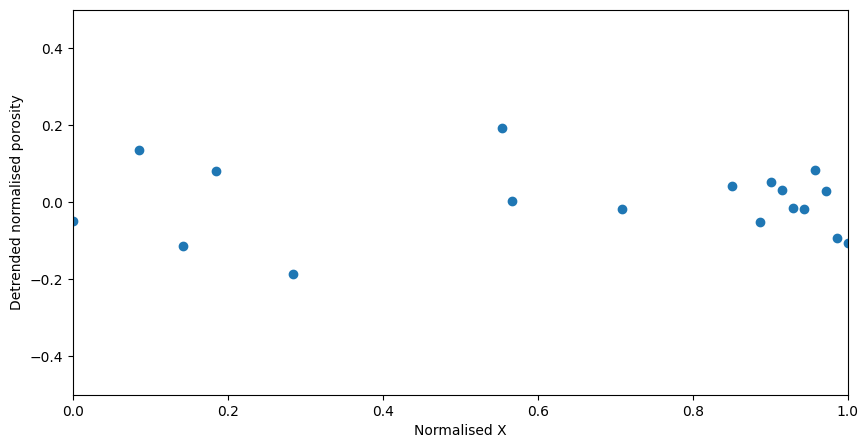

In [6]:
# Try to predict permeability from porosity, taking spatial collinearity into account

# Find the trend using a linear regressor
trend_poro = LinearRegression().fit(corr_df[['X']], corr_df["Porosity"])
trend_perm = LinearRegression().fit(corr_df[['X']], corr_df["Perm"])
# Detrend
corr_df['Poro_detrended'] = corr_df["Porosity"] - trend_poro.predict(corr_df[['X']])
corr_df['Perm_detrended'] = corr_df["Perm"] - trend_perm.predict(corr_df[['X']])
# Plot detrended porosity against X
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(corr_df['X'], corr_df["Poro_detrended"])
ax.set(xlabel="Normalised X", ylabel="Detrended normalised porosity", xlim=(0, 1), ylim=(-0.5, 0.5));

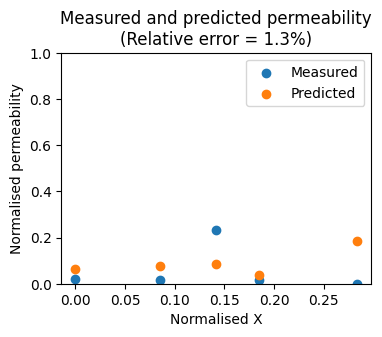

In [7]:
# Geographic train-test split (first 30% is test set)
X_test_detrended = corr_df["Poro_detrended"][:boundary].values.reshape(-1, 1)
y_test_detrended = corr_df["Perm_detrended"][:boundary].values
X_train_detrended = corr_df["Poro_detrended"][boundary:].values.reshape(-1, 1)
y_train_detrended = corr_df["Perm_detrended"][boundary:].values
# Predict using a KNN regressor
knn_detrended = KNeighborsRegressor().fit(X_train_detrended, y_train_detrended)
y_pred_detrended = knn_detrended.predict(X_test_detrended)
# Restore the trend (y = y_detrended (c) + mx)
y_pred = y_pred_detrended + trend_perm.coef_[0]*corr_df['X'][:boundary]
# Show the prediction result and error
error = mean_squared_error(y_test, y_pred)*100
fig, ax = plt.subplots(figsize=(4, 3))
ax.scatter(corr_df['X'][:boundary], y_test, label="Measured")
ax.scatter(corr_df['X'][:boundary], y_pred, label="Predicted")
ax.set(
    title=f"Measured and predicted permeability\n(Relative error = {error:.1f}%)",
    xlabel="Normalised X",
    ylabel="Normalised permeability",
    ylim=(0, 1))
ax.legend();